# Ignition delay computation
In this example, we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure.

The reactor (system) is simply an insulated box.

In [1]:
import pandas as pd
import numpy as np

import time

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.5.1


### Import modules and set plotting defaults

In [2]:
%matplotlib widget 
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

### Define the gas
In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species [mechanism](https://combustion.llnl.gov/archived-mechanisms/alkanes/heptane-reduced-mechanism) by [Seier et al. 2000, Proc. Comb. Inst](http://dx.doi.org/10.1016/S0082-0784&#40;00&#41;80610-4). 

In [3]:
gas = ct.Solution('../data/h2o2.yaml')

### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [4]:
# Define the reactor temperature and pressure
reactor_temperature = 1000  # Kelvin
reactor_pressure = 101325  # Pascals

# Define chemistry of fuel and oxidizer
fuel_, oxidizer_ = {"H2": 2.0, "O2": 0.01}, {"O2": 2.0, "N2": 3.76}

gas.TP = reactor_temperature, reactor_pressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel=fuel_, oxidizer=oxidizer_)

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
reactor_network = ct.ReactorNet([r])

# use the above list to create a DataFrame
time_history = ct.SolutionArray(gas, extra="t")

### Define useful functions

In [5]:
def ignition_delay(states, species):
    """
    This function computes the ignition delay from the occurence of the
    peak in species' concentration.
    """
    i_ign = states(species).Y.argmax()
    return states.t[i_ign]

In [6]:
reference_species = "OH"

# Tic
t0 = time.time()

# This is a starting estimate. If you do not get an ignition within this time, increase it
estimated_ignition_delay_time = 0.1
t = 0

counter = 1
while t < estimated_ignition_delay_time:
    t = reactor_network.step()
    if not counter % 10:
        # We will save only every 10th value. Otherwise, this takes too long
        # Note that the species concentrations are mass fractions
        time_history.append(r.thermo.state, t=t)
    counter += 1

# We will use the reference species to compute the ignition delay
tau = ignition_delay(time_history, reference_species)

# Toc
t1 = time.time()

print(f"Computed Ignition Delay: {tau:.3e} seconds. Took {t1-t0:3.2f}s to compute")

# If you want to save all the data - molefractions, temperature, pressure, etc
# uncomment the next line
# timeHistory.to_csv("time_history.csv")

Computed Ignition Delay: 2.399e-04 seconds. Took 0.02s to compute


## Plot the result

### Figure illustrating the definition of ignition delay

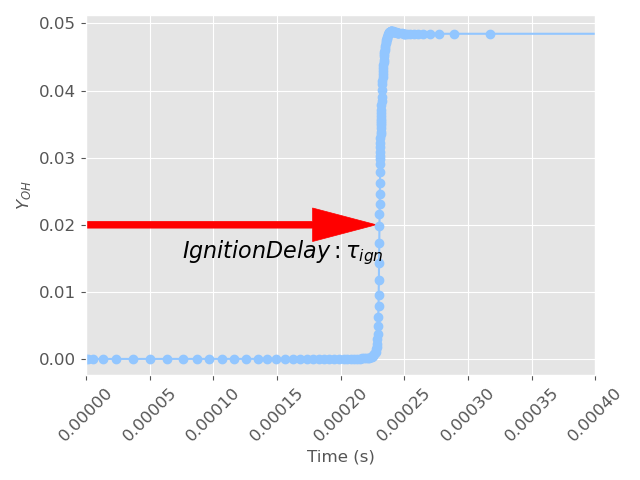

In [7]:
plt.figure()
plt.plot(time_history.t, time_history(reference_species).Y, "-o")
plt.xlabel("Time (s)")
plt.ylabel("$Y_{OH}$")

plt.xlim([0,4.0e-4])
plt.arrow(0, 0.02, tau * 0.95, 0, width=0.001, head_width=0.005,
          head_length=0.00005, length_includes_head=True, color="r", shape="full")
plt.annotate(r"$Ignition Delay: \tau_{ign}$", xy=(0,0.0), xytext=(0.000075, 0.015), fontsize=16);
_ = plt.xticks(rotation = 45)

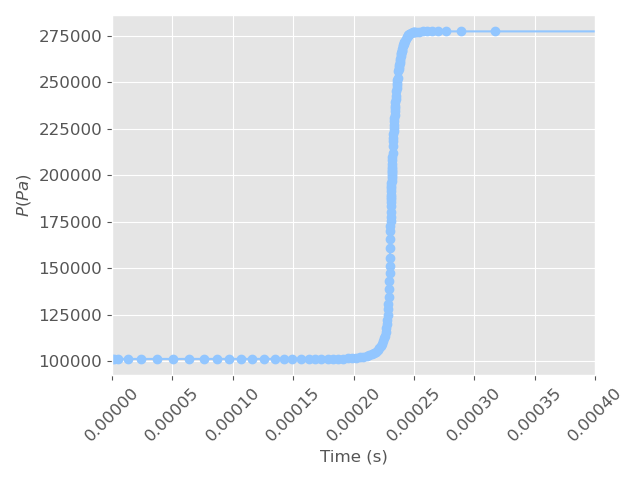

In [8]:
plt.figure()
plt.plot(time_history.t, time_history.P, "-o")
plt.xlabel("Time (s)")
plt.ylabel("$P (Pa)$")

plt.xlim([0,4.0e-4])
_ = plt.xticks(rotation = 45)

## Illustration : NTC behavior

A common benchmark for a reaction mechanism is its ability to reproduce the **N**egative **T**emperature **C**oefficient behavior. Intuitively, as the temperature of an explosive mixture increases, it should ignite faster. But, under certain conditions, we observe the opposite. This is referred to as NTC behavior. Reproducing experimentally observed NTC behavior is thus an important test for any mechanism. We will do this now by computing and visualizing the ignition delay for a wide range of temperatures

### Define the temperatures for which we will run the simulations

In [9]:
# Make a list of all the temperatures we would like to run simulations at
T = np.hstack((np.arange(1500, 600, -25), np.arange(975, 475, -25)))

estimated_ignition_delay_times = np.ones_like(T, dtype=float)

# Make time adjustments for the highest and lowest temperatures. This we do empirically
estimated_ignition_delay_times[:6] = 6 * [0.1]
estimated_ignition_delay_times[-4:-2] = 10
estimated_ignition_delay_times[-2:] = 100

# Now create a SolutionArray out of these
ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
ignition_delays.set_equivalence_ratio(1.0,  fuel=fuel_, oxidizer=oxidizer_)
ignition_delays.TP = T, reactor_pressure

Now, what we will do is simply run the code above the plots for each temperature.

In [10]:
for i, state in enumerate(ignition_delays):
    # Setup the gas and reactor
    gas.TPX = state.TPX
    r = ct.IdealGasReactor(contents=gas, name="Batch Reactor")
    reactor_network = ct.ReactorNet([r])

    reference_species_history = []
    time_history = []

    t0 = time.time()

    t = 0
    while t < estimated_ignition_delay_times[i]:
        t = reactor_network.step()
        time_history.append(t)
        reference_species_history.append(gas[reference_species].X[0])

    i_ign = np.array(reference_species_history).argmax()
    tau = time_history[i_ign]
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, state.T, t1-t0))

    ignition_delays.tau[i] = tau

Computed Ignition Delay: 1.266e-04 seconds for T=1500.0K. Took 0.04s to compute
Computed Ignition Delay: 1.280e-04 seconds for T=1475.0K. Took 0.03s to compute
Computed Ignition Delay: 1.197e-04 seconds for T=1450.0K. Took 0.03s to compute
Computed Ignition Delay: 1.376e-04 seconds for T=1425.0K. Took 0.03s to compute
Computed Ignition Delay: 2.147e-04 seconds for T=1400.0K. Took 0.03s to compute
Computed Ignition Delay: 1.396e-04 seconds for T=1375.0K. Took 0.03s to compute
Computed Ignition Delay: 1.289e-04 seconds for T=1350.0K. Took 0.03s to compute
Computed Ignition Delay: 1.222e-04 seconds for T=1325.0K. Took 0.03s to compute
Computed Ignition Delay: 1.403e-04 seconds for T=1300.0K. Took 0.03s to compute
Computed Ignition Delay: 1.442e-04 seconds for T=1275.0K. Took 0.03s to compute
Computed Ignition Delay: 1.244e-04 seconds for T=1250.0K. Took 0.03s to compute
Computed Ignition Delay: 1.203e-04 seconds for T=1225.0K. Took 0.03s to compute
Computed Ignition Delay: 1.437e-04 secon

### Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$). 

In [11]:
df_ignition_delays = ignition_delays.to_pandas(cols=['T', 'tau']).set_index('T')

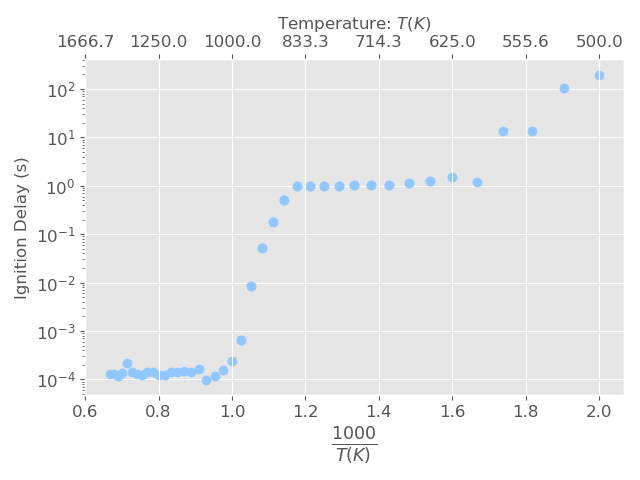

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(1000/ignition_delays.T, ignition_delays.tau, 'o')
ax.set_ylabel('Ignition Delay (s)')
ax.set_xlabel(r'$\frac{1000}{T (K)}$', fontsize=18)

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'Temperature: $T(K)$');